Available sheets: ['Contents - 3rd release', 'Population', 'Providers and Services', 'Client Summary', 'Expenditure Summary', 'Assessments and approvals', 'Home Care', 'Residential Care', 'Transition Care', 'Home Support', 'Short Term Restorative Care']
Cleaned and processed dataset:


,Residential_Care_Clients,Home_Care_Clients,Total_Elderly,Total_Care_Clients,Care_Supply_Ratio
State,,,,,
NSW,59298.0,83768.0,8673867.01,143066.0,16.49
Vic,47677.0,66674.0,7183220.00,114351.0,15.92
Qld,37701.0,53631.0,5449923.00,91332.0,16.76
WA,17207.0,21827.0,2765994.00,39034.0,14.11
SA,15909.0,22889.0,1799773.00,38798.0,21.56
Tas,4459.0,6115.0,547105.00,10574.0,19.33
ACT,2386.0,2396.0,464083.00,4782.0,10.30
NT,490.0,1074.0,263224.00,1564.0,5.94
Aust,185127.0,258374.0,27147189.01,443501.0,16.34


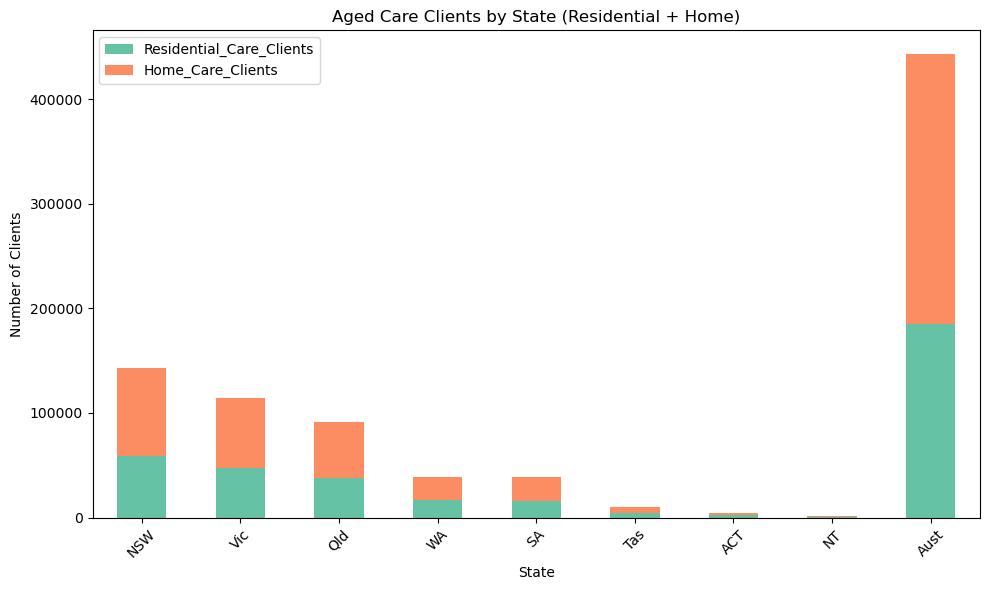

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import warnings
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import numpy as np
import plotly.express as px
from IPython.display import display

# Ignore warnings
warnings.filterwarnings("ignore")

# Load the Excel file
xlsx = pd.ExcelFile('Aged-Care-Data-Snapshot-2023-Release-3.xlsx')
print("Available sheets:", xlsx.sheet_names)

# Parse sheets with appropriate row skips
home_care_df = xlsx.parse('Home Care', skiprows=6)
residential_care_df = xlsx.parse('Residential Care', skiprows=6)
population_df = xlsx.parse('Population', skiprows=6)

# Extract relevant data
states = ['NSW', 'Vic', 'Qld', 'WA', 'SA', 'Tas', 'ACT', 'NT', 'Aust']
home_clients = home_care_df.iloc[3, 1:10].astype(float).values
res_clients = residential_care_df.iloc[4, 1:10].astype(float).values
female_pop = population_df.iloc[3, 1:10].astype(float).values
male_pop = population_df.iloc[4, 1:10].astype(float).values
total_elderly = female_pop + male_pop

# Create cleaned DataFrame
df = pd.DataFrame({
    'State': states,
    'Residential_Care_Clients': res_clients,
    'Home_Care_Clients': home_clients,
    'Total_Elderly': total_elderly
})
df.set_index('State', inplace=True)

# Feature Engineering
df['Total_Care_Clients'] = df['Residential_Care_Clients'] + df['Home_Care_Clients']
df['Care_Supply_Ratio'] = df['Total_Care_Clients'] / df['Total_Elderly'] * 1000

# Print Cleaned Table
print("Cleaned and processed dataset:")
display(df.round(2))

# KMeans Clustering
X = df[['Total_Elderly', 'Care_Supply_Ratio']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Linear Regression
reg = LinearRegression()
reg.fit(df[['Total_Elderly']], df['Total_Care_Clients'])
df['Predicted_Care'] = reg.predict(df[['Total_Elderly']])

# --- PLOTS ---

# 1. Stacked Bar Chart of Care Clients
df[['Residential_Care_Clients', 'Home_Care_Clients']].plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#66c2a5', '#fc8d62']
)
plt.title('Aged Care Clients by State (Residential + Home)')
plt.ylabel('Number of Clients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

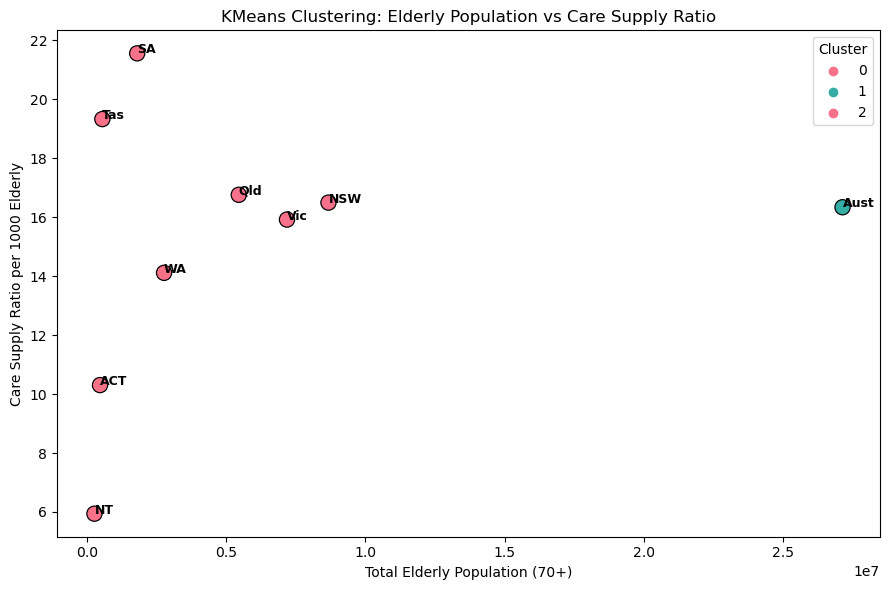

In [6]:
# 2. Scatter Plot with Clusters
plt.figure(figsize=(9, 6))
sns.scatterplot(
    x='Total_Elderly', y='Care_Supply_Ratio', hue='Cluster',
    palette='husl', data=df, s=120, edgecolor='black'
)
for i in df.index:
    plt.text(df.loc[i, 'Total_Elderly'] + 1000, df.loc[i, 'Care_Supply_Ratio'],
             i, fontsize=9, weight='bold')
plt.title('KMeans Clustering: Elderly Population vs Care Supply Ratio')
plt.xlabel('Total Elderly Population (70+)')
plt.ylabel('Care Supply Ratio per 1000 Elderly')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

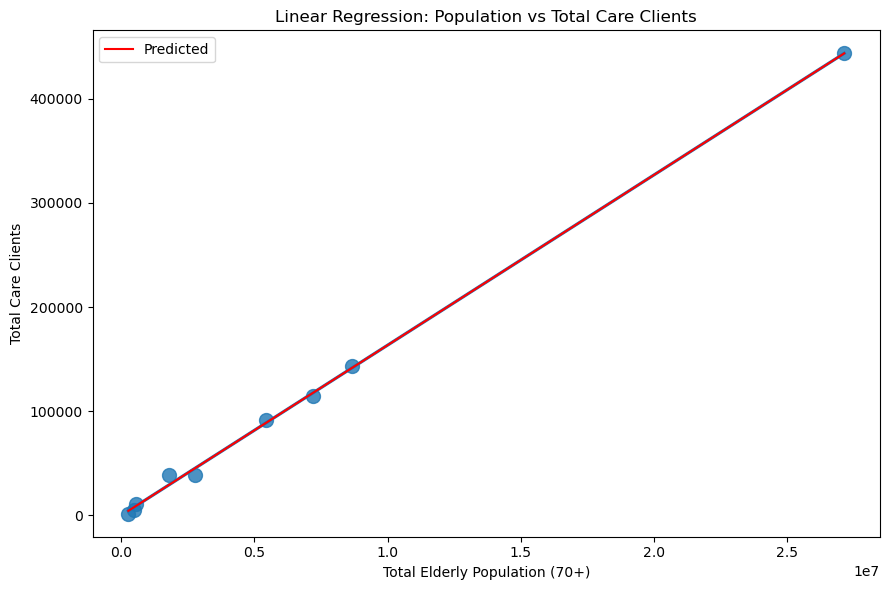

In [7]:
# 3. Regression Line with Prediction
plt.figure(figsize=(9, 6))
sns.regplot(x='Total_Elderly', y='Total_Care_Clients', data=df, ci=None, scatter_kws={'s': 100})
sns.lineplot(x='Total_Elderly', y='Predicted_Care', data=df, color='red', label='Predicted')
plt.title('Linear Regression: Population vs Total Care Clients')
plt.xlabel('Total Elderly Population (70+)')
plt.ylabel('Total Care Clients')
plt.legend()
plt.tight_layout()
plt.show()

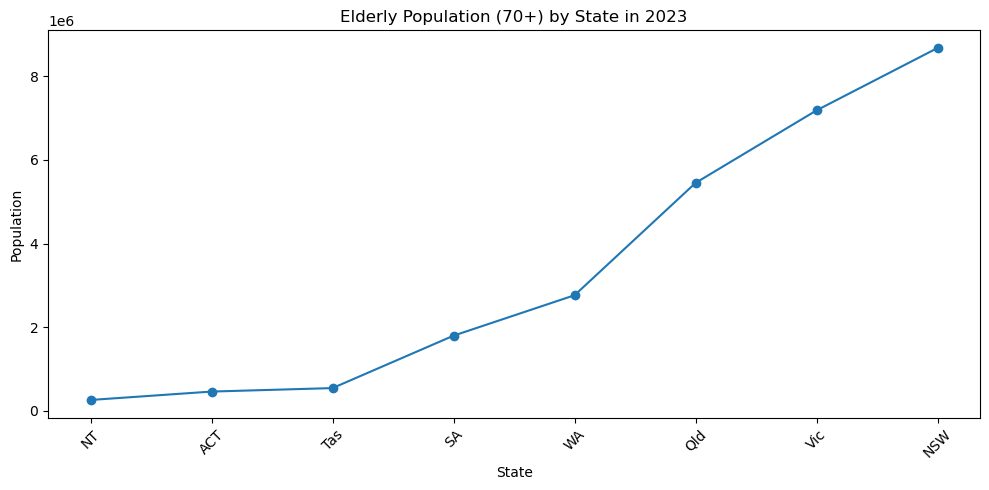

In [8]:
# 4. Line Chart – Elderly Population by State (2023)
plt.figure(figsize=(10, 5))
df.drop('Aust').sort_values('Total_Elderly')['Total_Elderly'].plot(kind='line', marker='o', color='#1f77b4')
plt.title('Elderly Population (70+) by State in 2023')
plt.ylabel('Population')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Table of final cluster membership
cluster_table = df[['Residential_Care_Clients', 'Home_Care_Clients', 'Total_Elderly', 'Care_Supply_Ratio', 'Cluster']]
cluster_table = cluster_table.drop('Aust')  # Remove national aggregate if present
cluster_table.to_csv("cluster_membership_table.csv")
print(cluster_table)


       Residential_Care_Clients  Home_Care_Clients  Total_Elderly  \
State                                                               
NSW                     59298.0            83768.0   8.673867e+06   
Vic                     47677.0            66674.0   7.183220e+06   
Qld                     37701.0            53631.0   5.449923e+06   
WA                      17207.0            21827.0   2.765994e+06   
SA                      15909.0            22889.0   1.799773e+06   
Tas                      4459.0             6115.0   5.471050e+05   
ACT                      2386.0             2396.0   4.640830e+05   
NT                        490.0             1074.0   2.632240e+05   

       Care_Supply_Ratio  Cluster  
State                              
NSW            16.493912        2  
Vic            15.919184        2  
Qld            16.758402        2  
WA             14.112106        0  
SA             21.557163        0  
Tas            19.327186        0  
ACT            10.304

In [10]:
from sklearn.metrics import r2_score

r_squared = r2_score(df['Total_Care_Clients'], df['Predicted_Care'])
print(f"R-squared value for the regression model: {r_squared:.4f}")


R-squared value for the regression model: 0.9990
